In [1]:
# import statements and functions to clean columns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import tqdm
import folium
from collections import Counter
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
# function to load and clean data

def load_data(separate=False):
    """
    loads and cleans the data.
    
    separate parameter returns separate target and predictors, if True
    """
    X = pd.read_csv('training_values.csv')
    y = pd.read_csv('training_labels.csv')
    
    # encode statuses
    #y['status'] = y.status_group.apply(lambda x: statuses[x])
    
    # encode tsh
    X.amount_tsh = X.amount_tsh.apply(encode_tsh)
    
    # modify gps_height to one-hot
    X.gps_height = X.gps_height.apply(lambda x: int(x != 0))
    
    # convert date_recorded to datetime 'phase'
    X.date_recorded = pd.to_datetime(X.date_recorded, errors='coerce')
    X.date_recorded = X.date_recorded.apply(encode_date_recorded)
    
    # set known permits equal to 1, all else equal to 1
    X.permit = X.permit.apply(lambda x: 1 if x else 0)
    
    # set water quality to 1 for 'known to be good' and 0 otherwise
    X.water_quality = X.water_quality.apply(lambda x: int(x == 'soft'))
    
    # encode quantity: 2 for 'enough', 1 for 'insufficient', 0 for everything else
    X.quantity = X.quantity.apply(encode_quantity)
    
    # encode payment in terms of 'number of payments per year' (or -1 if unknown)
    X.payment = X.payment.apply(encode_payment)
    
    # encode source (negative: underground. 0: surface. positive: above ground)
    X.source = X.source.apply(encode_source)
    
    # encode extraction type: hand, powered, or nature
    X.extraction_type = X.extraction_type.apply(encode_extraction_type)
    X = X[columns_to_keep]
    
    if separate:
        return X, y
    
    else:
        return pd.merge(X, y, left_on='id', right_on='id')

load_data(separate=False).head(2)

,id,date_recorded,amount_tsh,gps_height,latitude,longitude,basin,lga,population,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group
0,69572,1,2,1,-9.856322,34.938093,Lake Nyasa,Ludewa,109,0,nature,vwc,1,1,2,-1,communal standpipe,functional
1,8776,4,0,1,-2.147466,34.698766,Lake Victoria,Serengeti,280,1,nature,wug,0,1,1,1,communal standpipe,functional


In [5]:
def load_dummies():
    """
    one-hot encodes the categorical variables we found to be most important.
    """
    return pd.get_dummies(data=load_data().drop('id', axis=1), columns=['basin', 
                                                                        'lga', 
                                                                        'extraction_type', 
                                                                        'management', 
                                                                        'waterpoint_type'])
load_dummies()

,date_recorded,amount_tsh,gps_height,latitude,longitude,population,permit,payment,water_quality,quantity,source,status_group,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,lga_Arusha Rural,lga_Arusha Urban,lga_Babati,lga_Bagamoyo,lga_Bahi,lga_Bariadi,lga_Biharamulo,lga_Bukoba Rural,lga_Bukoba Urban,lga_Bukombe,lga_Bunda,lga_Chamwino,lga_Chato,lga_Chunya,lga_Dodoma Urban,lga_Geita,lga_Hai,lga_Hanang,lga_Handeni,lga_Igunga,lga_Ilala,lga_Ileje,lga_Ilemela,lga_Iramba,lga_Iringa Rural,lga_Kahama,lga_Karagwe,lga_Karatu,lga_Kasulu,lga_Kibaha,lga_Kibondo,lga_Kigoma Rural,lga_Kigoma Urban,lga_Kilindi,lga_Kilolo,lga_Kilombero,lga_Kilosa,lga_Kilwa,lga_Kinondoni,lga_Kisarawe,lga_Kishapu,lga_Kiteto,lga_Kondoa,lga_Kongwa,lga_Korogwe,lga_Kwimba,lga_Kyela,lga_Lindi Rural,lga_Lindi Urban,lga_Liwale,lga_Longido,lga_Ludewa,lga_Lushoto,lga_Mafia,lga_Magu,lga_Makete,lga_Manyoni,lga_Masasi,lga_Maswa,lga_Mbarali,lga_Mbeya Rural,lga_Mbinga,lga_Mbozi,lga_Mbulu,lga_Meatu,lga_Meru,lga_Misenyi,lga_Missungwi,lga_Mkinga,lga_Mkuranga,lga_Monduli,lga_Morogoro Rural,lga_Morogoro Urban,lga_Moshi Rural,lga_Moshi Urban,lga_Mpanda,lga_Mpwapwa,lga_Mtwara Rural,lga_Mtwara Urban,lga_Mufindi,lga_Muheza,lga_Muleba,lga_Musoma Rural,lga_Mvomero,lga_Mwanga,lga_Nachingwea,lga_Namtumbo,lga_Nanyumbu,lga_Newala,lga_Ngara,lga_Ngorongoro,lga_Njombe,lga_Nkasi,lga_Nyamagana,lga_Nzega,lga_Pangani,lga_Rombo,lga_Rorya,lga_Ruangwa,lga_Rufiji,lga_Rungwe,lga_Same,lga_Sengerema,lga_Serengeti,lga_Shinyanga Rural,lga_Shinyanga Urban,lga_Siha,lga_Sikonge,lga_Simanjiro,lga_Singida Rural,lga_Singida Urban,lga_Songea Rural,lga_Songea Urban,lga_Sumbawanga Rural,lga_Sumbawanga Urban,lga_Tabora Urban,lga_Tandahimba,lga_Tanga,lga_Tarime,lga_Temeke,lga_Tunduru,lga_Ukerewe,lga_Ulanga,lga_Urambo,lga_Uyui,extraction_type_human,extraction_type_nature,extraction_type_power,extraction_type_unknown,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,1,2,1,-9.856322,34.938093,109,0,1,1,2,-1,functional,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,4,0,1,-2.147466,34.698766,280,1,0,1,1,1,functional,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,4,1,1,-3.821329,37.460664,250,1,3,1,2,0,functional,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,4,0,1,-11.155298,38.486161,58,1,0,1,0,0,non functional,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,2,0,0,-1.825359,31.130847,0,1,0,1,0,1,functional,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [6]:
# split the data into training and test sets

from sklearn.model_selection import train_test_split
df = load_dummies()
X = df.drop('status_group', axis=1)
y = df.status_group.apply(lambda x: statuses[x])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [7]:
# run a GridSearch on the DecisionTreeClassifier to find the best parameters.
# we tested a variety of values and got the best results with these.

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, make_scorer

param_grid = {
    'criterion':['gini', 'entropy'],
    'splitter':['best'],
    'max_depth':[5, 10, 15],
    'min_samples_split':[2, 3, 5, 7],
    'min_samples_leaf':[1]
}

def get_false_positives(y_true, y_pred):
    """
    returns the number of overlooked wells (i.e. the number of non functional wells
    that were misclassified as functional)
    """
    return confusion_matrix(y_true, y_pred)[2][0]

# create a new scorer for the GridSearchCV
# greater_is_better is the opposite of what we want, so set to False
fp_scorer = make_scorer(get_false_positives, greater_is_better=False)

# grid search over the parameters using the scorer, return the parameters that minimize
# the overlook rate
gs_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=6, scoring=fp_scorer)
gs_tree.fit(X_train, y_train)
gs_tree.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1695.000, total=   0.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1667.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1778.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1611.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, splitter=best, score=-1685.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1695.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1666.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1778.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1611.000, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=3, splitter=best, score=-1685.000, total=   0.2s
[CV] criterion=gini, max_depth

KeyboardInterrupt: 

0.8135942760942761
Overlook Rate: 0.2722398511872196


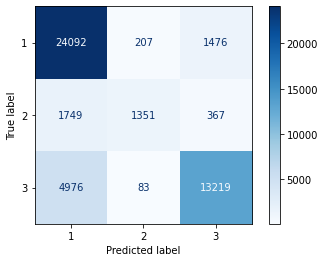

In [8]:
from sklearn.tree import DecisionTreeClassifier

# determined from the GridSearchCV above
best_params = {'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

def get_false_positives(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[2][0]

dt = DecisionTreeClassifier(**best_params)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_train)
print(accuracy_score(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)
print('Overlook Rate:', cm[2][0] / sum(cm[2][i] for i in range(3)))
plot_confusion_matrix(dt, X_train, y_train, cmap='Blues')

0.7585016835016835
0.3167619885613726


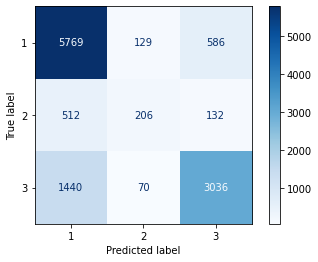

In [9]:
# test the model on the test data

y_test_pred = dt.predict(X_test)
print(accuracy_score(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
print(cm[2][0] / sum(cm[2][i] for i in range(3)))
plot_confusion_matrix(dt, X_test, y_test, cmap='Blues')

In [21]:
# investigating why some wells are misclassified as functional 
# even though they are non functional

df = pd.merge(X, y, left_index=True, right_index=True)
df['prediction'] = dt.predict(X)
df

overlooked = df[(df.status_group == 3) & (df.prediction == 1)]
overlooked.describe()

,date_recorded,amount_tsh,gps_height,latitude,longitude,population,permit,payment,water_quality,quantity,source,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,lga_Arusha Rural,lga_Arusha Urban,lga_Babati,lga_Bagamoyo,lga_Bahi,lga_Bariadi,lga_Biharamulo,lga_Bukoba Rural,lga_Bukoba Urban,lga_Bukombe,lga_Bunda,lga_Chamwino,lga_Chato,lga_Chunya,lga_Dodoma Urban,lga_Geita,lga_Hai,lga_Hanang,lga_Handeni,lga_Igunga,lga_Ilala,lga_Ileje,lga_Ilemela,lga_Iramba,lga_Iringa Rural,lga_Kahama,lga_Karagwe,lga_Karatu,lga_Kasulu,lga_Kibaha,lga_Kibondo,lga_Kigoma Rural,lga_Kigoma Urban,lga_Kilindi,lga_Kilolo,lga_Kilombero,lga_Kilosa,lga_Kilwa,lga_Kinondoni,lga_Kisarawe,lga_Kishapu,lga_Kiteto,lga_Kondoa,lga_Kongwa,lga_Korogwe,lga_Kwimba,lga_Kyela,lga_Lindi Rural,lga_Lindi Urban,lga_Liwale,lga_Longido,lga_Ludewa,lga_Lushoto,lga_Mafia,lga_Magu,lga_Makete,lga_Manyoni,lga_Masasi,lga_Maswa,lga_Mbarali,lga_Mbeya Rural,lga_Mbinga,lga_Mbozi,lga_Mbulu,lga_Meatu,lga_Meru,lga_Misenyi,lga_Missungwi,lga_Mkinga,lga_Mkuranga,lga_Monduli,lga_Morogoro Rural,lga_Morogoro Urban,lga_Moshi Rural,lga_Moshi Urban,lga_Mpanda,lga_Mpwapwa,lga_Mtwara Rural,lga_Mtwara Urban,lga_Mufindi,lga_Muheza,lga_Muleba,lga_Musoma Rural,lga_Mvomero,lga_Mwanga,lga_Nachingwea,lga_Namtumbo,lga_Nanyumbu,lga_Newala,lga_Ngara,lga_Ngorongoro,lga_Njombe,lga_Nkasi,lga_Nyamagana,lga_Nzega,lga_Pangani,lga_Rombo,lga_Rorya,lga_Ruangwa,lga_Rufiji,lga_Rungwe,lga_Same,lga_Sengerema,lga_Serengeti,lga_Shinyanga Rural,lga_Shinyanga Urban,lga_Siha,lga_Sikonge,lga_Simanjiro,lga_Singida Rural,lga_Singida Urban,lga_Songea Rural,lga_Songea Urban,lga_Sumbawanga Rural,lga_Sumbawanga Urban,lga_Tabora Urban,lga_Tandahimba,lga_Tanga,lga_Tarime,lga_Temeke,lga_Tunduru,lga_Ukerewe,lga_Ulanga,lga_Urambo,lga_Uyui,extraction_type_human,extraction_type_nature,extraction_type_power,extraction_type_unknown,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,status_group,prediction
count,6416.000000,6416.000000,6416.000000,6.416000e+03,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.00000,6416.000000,6416.000000,6416.000000,6416.000000,6416.0,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.00000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.0,6416.000000,6416.000000,6416.000000,6416.000000,6416.0,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.00000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.0,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.000000,6416.0,6416.000000,6416.000000,6416.00000,6416.000000,64

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,9))
plt.axvspan(-.5, .5, color='green', alpha=0.2)
plt.axvspan(.5, 1.5, color='yellow', alpha=0.2)
plt.axvspan(1.5, 2.5, color='red', alpha=0.2)
countplot = sns.countplot(x='status_group', 
              hue='basin', 
              order=['functional', 'functional needs repair', 'non functional'],
              data=load_data(), 
              ax=ax, 
              palette=sns.color_palette("Greys_d", n_colors=9))
plt.yticks(ticks=[1000, 2000, 3000, 4000, 5000], labels=[])
plt.xticks(ticks=[0, 1, 2], labels=['Functional', 'Functional Needs Repair', 'Non Functional'], fontsize=14)
plt.ylabel('Number of Pumps', fontsize=18)
plt.xlabel('')
plt.savefig('pump-status-by-basin.png')
ax.set_title('Pump Status By Basin', fontsize=24)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,9))
df = load_data()
quality_codes = {1:'Known to be good', 0:'Other'}
df.water_quality = df.water_quality.apply(lambda x: quality_codes[x])
sns.countplot(x='status_group', 
              hue='water_quality', 
              data=df, 
              ax=ax, 
              palette=sns.color_palette("Blues_d", n_colors=2))
#plt.savefig('pump-status-by-basin.png')
ax.set_title('Pump Status By Quality')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,9))
df = load_data()
tsh_codes = {2:'> 250', 1:'0-250', 0:'0'}
df.amount_tsh = df.amount_tsh.apply(lambda x: tsh_codes[x])
sns.countplot(x='status_group', 
              hue='amount_tsh', 
              data=df, 
              ax=ax, 
              palette=sns.color_palette("Blues_d", n_colors=3))
#plt.savefig('pump-status-by-basin.png')
ax.set_title('Pump Status By Total Static Head')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,9))
df = load_data()
sns.countplot(x='status_group', 
              hue='date_recorded', 
              data=df, 
              ax=ax, 
              palette=sns.color_palette("Blues_d", n_colors=5))
#plt.savefig('pump-status-by-basin.png')
ax.set_title('Pump Status By Phase')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,9))
df = load_data()

quantity_codes = {2:'enough', 1:'insufficient', 0:'other'}

df.quantity = df.quantity.apply(lambda x: quantity_codes[x])

sns.countplot(x='status_group', 
              hue='quantity', 
              data=df, 
              ax=ax, 
              palette=sns.color_palette("Blues_d", n_colors=3))
#plt.savefig('pump-status-by-basin.png')
ax.set_title('Pump Status By Quantity')